# Build the KNN model 

Now that the data is prepared we can build the model for predictions an evaluations. <br>
I will be using the K nearest neighbours model to find organisations that are similar to each other. 

In [2]:
# Import libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.colors import ListedColormap
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sqlalchemy import create_engine

%matplotlib inline

In [3]:
engine = create_engine('sqlite:///../data/orgs_customer_behaviours.db')
df_normalised_features = pd.read_sql_table('synth_customer_behaviour_data', engine)
df_features = pd.read_sql_table('synth_customer_target_classifier_data', engine)

In [4]:
X = df_normalised_features
y = df_features['CONVERTED']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_neighbors = 1
knn = KNeighborsClassifier(n_neighbors=num_neighbors)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

In [5]:
print(f'WITH K={num_neighbors}\n')
print('\nCONFUSION MATRIX:')
print(confusion_matrix(y_test, pred))
print('\nCLASSIFICATION REPORT:')
print(classification_report(y_test,pred))

WITH K=1


CONFUSION MATRIX:
[[81 10]
 [10 99]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        91
           1       0.91      0.91      0.91       109

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



#### Improve the model with a better K value
The initial K value was arbitrary to prove the functioning of the model. <br>
Lets try to improve accuracy by finding a better K value for KNN

In [6]:
error_rate = []

for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

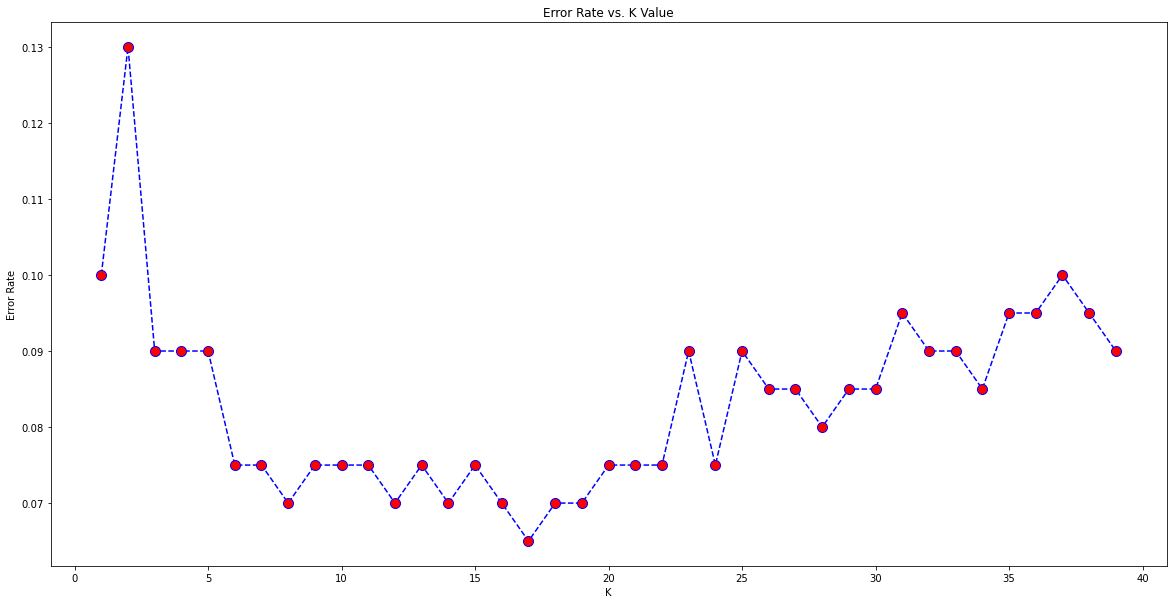

In [8]:
plt.figure(figsize=(20, 10))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [9]:
num_neighbors = 40
knn = KNeighborsClassifier(n_neighbors=num_neighbors)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

In [10]:
print(f'WITH K={num_neighbors}\n')
print('\nCONFUSION MATRIX:')
print(confusion_matrix(y_test, pred))
print('\nCLASSIFICATION REPORT:')
print(classification_report(y_test,pred))

WITH K=40


CONFUSION MATRIX:
[[82  9]
 [11 98]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        91
           1       0.92      0.90      0.91       109

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



In [11]:
grid_parameters = {
    'n_neighbors': [5, 10, 18, 20, 25, 35, 40],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

gs = GridSearchCV(KNeighborsClassifier(), grid_parameters, verbose=1, cv=3, n_jobs=-1)

gs_results = gs.fit(X_train, y_train)

print(f'\n\nBest scores found are {gs_results.best_score_}\n\n')
print(f'Best results are found using estimator {gs_results.best_estimator_}\n\n')

Fitting 3 folds for each of 28 candidates, totalling 84 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best scores found are 0.8937559253940094


Best results are found using estimator KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance')


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    2.7s finished


In [13]:
num_neighbors = 10
knn = KNeighborsClassifier(n_neighbors=num_neighbors, weights='distance', metric='manhattan')
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

print(f'WITH K={num_neighbors}\n')
print('\nCONFUSION MATRIX:')
print(confusion_matrix(y_test, pred))
print('\nCLASSIFICATION REPORT:')
print(classification_report(y_test,pred))

WITH K=10


CONFUSION MATRIX:
[[ 81  10]
 [  6 103]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        91
           1       0.91      0.94      0.93       109

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



### PCA

Lets reduce the dimensions to see if we can improve the outcomes and vizualise the model for analysis.

In [14]:
pca = PCA(n_components=2)

X_train_n2 = pca.fit_transform(X_train)
knn.fit(X_train_n2, y_train)

print(f'WITH K={num_neighbors}\n')
print('\nCONFUSION MATRIX:')
print(confusion_matrix(y_test, pred))
print('\nCLASSIFICATION REPORT:')
print(classification_report(y_test,pred))

WITH K=10


CONFUSION MATRIX:
[[ 81  10]
 [  6 103]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        91
           1       0.91      0.94      0.93       109

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



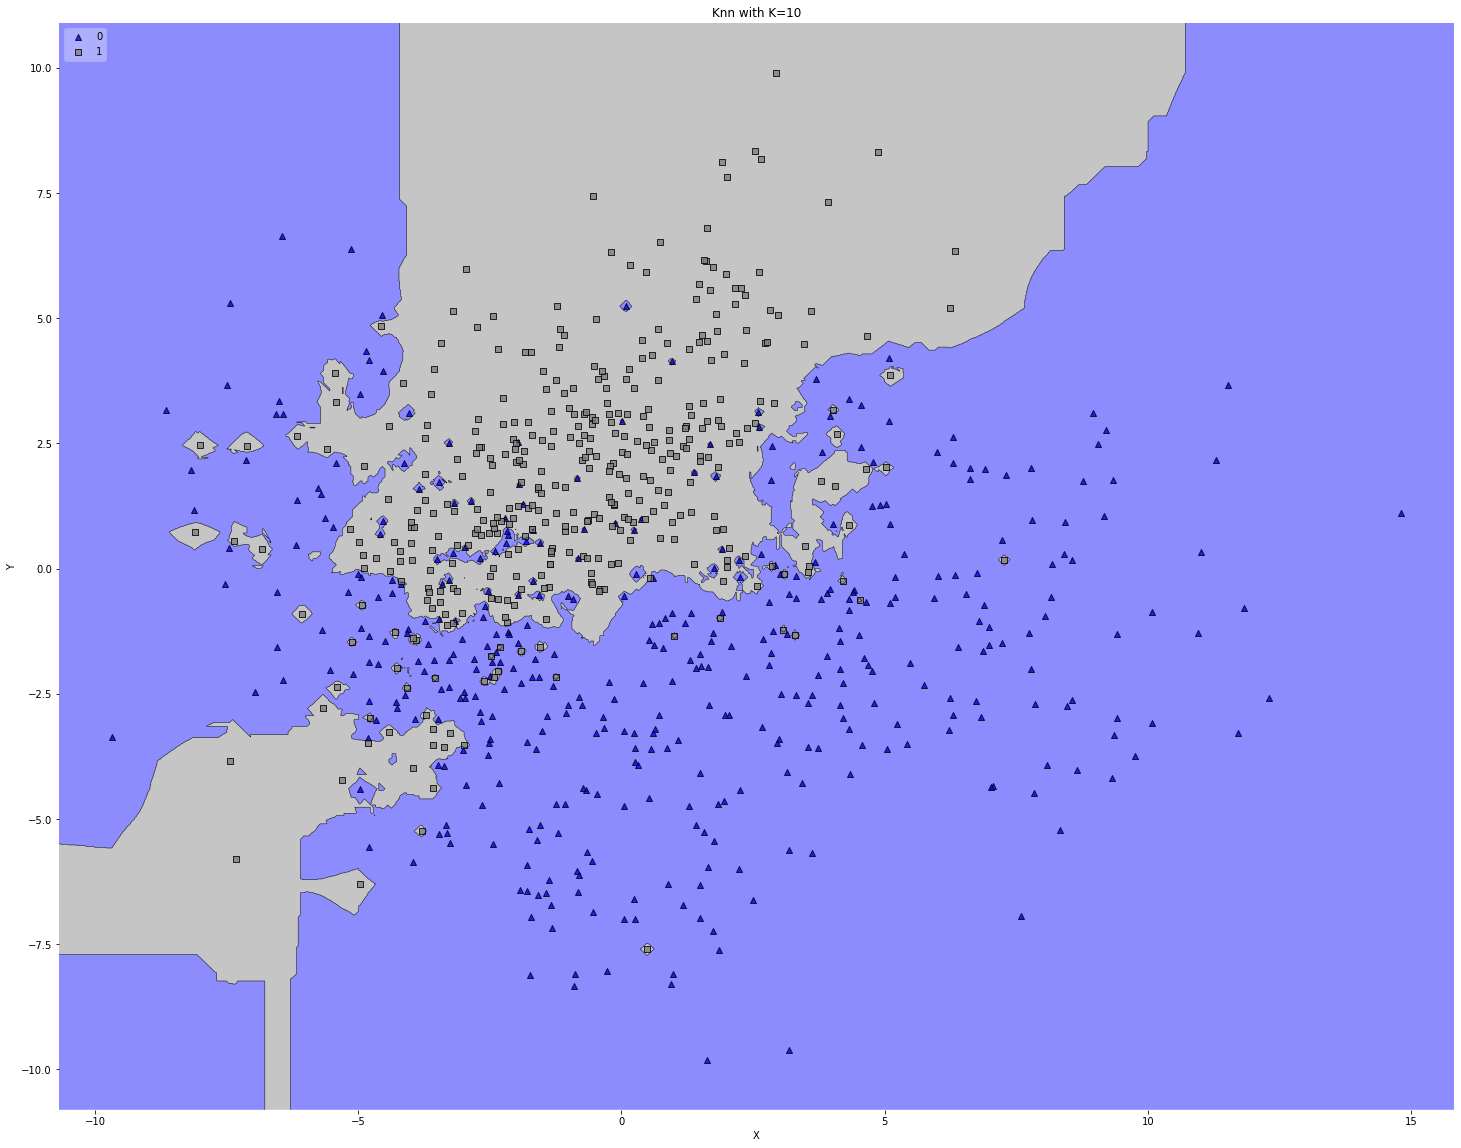

In [15]:
#  X_npa = X_train_n2.to_numpy()
y_npa = y_train.to_numpy()

plt.rcParams['figure.figsize'] = [25, 20]
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Knn with K='+ str(num_neighbors))
plot_decision_regions(X_train_n2, y_npa, clf=knn, legend=2, colors='blue,grey,darkblue,darkgrey', markers='^s')# Adding axes annotations
plt.show()